In [21]:
import sys
sys.path.append("../src")
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from utils.common.pathManager import FilePath
import pandas as pd
import numpy as np

# Gready

$$ \text{min}(\text{Var}(S_1,S_2,S_3,S_4) =  \frac{1}{n}\sum_{i=1}^{4}{(S_i - \bar{S})^2})$$

In [22]:
import math


def normalize_array(x):
    """Normalize a numpy array to the range [0, 1]."""
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)


def find_best_sample(non_empty_df: pd.DataFrame, dmg_size: int, labels: list, balance_imp: float) -> pd.DataFrame:
    """
    Iteratively explores all possible slices of contiguous rows of length `dmg_size` from a DataFrame sorted by imbalance.
    To find the best sample, it combines two functions weighted by `balance_imp`: 
    one expressing the total number of buildings in each slice and the other expressing the imbalance of damage classes present in `labels`.
    This aggregation allows for identifying the point where the total number of buildings is maximized 
    and the class imbalance is minimized, returning a sample with a trade-off between total buildings and damage class imbalance.

    Args:
        non_empty_df (pd.DataFrame): The DataFrame containing rows without empty entries.
        dmg_size (int): The size of the slice of contiguous rows to explore.
        labels (list): The list of column names representing the damage labels for imbalance calculation.
        balance_imp (float): Importance weight of class imbalance vs total number of buildings.
            - If greater than 0.5, prioritizes solutions with lower class imbalance.
            - If equal to 0.5, balances both objectives equally.
            - If less than 0.5, prioritizes solutions with more total buildings, possibly with higher imbalance.

    Returns:
        pd.DataFrame: The sample from the DataFrame that best balances building count and damage class imbalance.
    """
    bld_tot_f = []
    imbalance_f = []
    print("Exploring posible data samples...")
    for i in trange(0, len(non_empty_df)-dmg_size, desc="Searching best sample"):
        sample = non_empty_df.iloc[i:i+dmg_size]
        bld_tot = sample.sum(axis=0, numeric_only=True).sum()
        arr = sample[labels].sum(axis=0, numeric_only=True).to_numpy()
        imbalance = mean_square_error(np.array([arr]))[0]
        bld_tot_f.append(bld_tot)
        imbalance_f.append(imbalance)
    print(f"{len(imbalance_f)} possible samples explored.")
    norm_bld_tot = normalize_array(np.array(bld_tot_f))
    norm_imbalance = normalize_array(np.array(imbalance_f))
    beta = 100 * balance_imp  # Peso para f1
    alpha = 100 - beta   # Peso para f2
    combined_func = alpha * norm_bld_tot - beta * norm_imbalance
    norm_g = normalize_array(combined_func)
    id = norm_g.argmax()
    print(f"Selected sample from {id} to {id + dmg_size} index.")
    return non_empty_df.iloc[id:id+dmg_size]


def best_sample_search(non_empty_df, empty_df, total_img: int, labels: list, balance_imp=0.7, empty_prop=0.2):

    print("Searching for the best sample.")
    if total_img > len(non_empty_df):
        raise ValueError(
            "El tamaño de la muestra no puede ser mayor que la longitud del DataFrame.")

    empty_size = math.floor(total_img * empty_prop)
    dmg_size = total_img - empty_size

    dmg_sample = find_best_sample(non_empty_df, dmg_size, labels, balance_imp)

    # sampling the selected slice of instances.
    dmg_sample = dmg_sample.reset_index()
    proportions = dmg_sample.value_counts("dis_id")
    proportions = proportions / proportions.sum()
    img_num_by_dis = (empty_size * proportions).apply(lambda x: round(x))

    # proportional sample of images without damaged buildings
    empty_sample = empty_df.reset_index(drop=True)
    empty_sample = empty_df.groupby(["dis_id"]).apply(
        lambda x: x.sample(n=img_num_by_dis[x.name], replace=True),
        include_groups=False)
    empty_sample: pd.DataFrame = empty_sample.reset_index()
    empty_sample.drop(columns=["level_1"], inplace=True)
    return pd.concat([dmg_sample, empty_sample], axis=0)


def mean_square_error(matrix_arr: np.ndarray) -> np.ndarray:
    """Returns the error for each row in the np.array matrix"""
    matrix_arr: np.ndarray = matrix_arr.astype(float)
    matrix_arr -= matrix_arr.mean(axis=1)[:, np.newaxis]
    matrix_arr = matrix_arr**2
    return matrix_arr.sum(axis=1) / matrix_arr.shape[1]


def get_best_candidate(candidates_df: pd.DataFrame, total_arr: np.ndarray) -> pd.DataFrame:
    """Returns the row with less MSE value"""
    cand_matrix: np.ndarray = candidates_df.to_numpy(copy=True)
    cand_matrix += total_arr
    points = mean_square_error(cand_matrix) - mean_square_error(np.array([total_arr]))
    return candidates_df.iloc[points.argmin()].name


def sort_by_imbalance(df: pd.DataFrame, labels: list) -> pd.DataFrame:
    """
    Implementation of a greedy strategy to iteratively select the image that has the least impact
    on the imbalance of the current damage label distribution. The result is a sorted DataFrame where
    contiguous rows are arranged to minimize the imbalance ratio between all classes. 
    (This property is true until certain row in the dataframe because this method only sorts the
    dataset and do not drop any row.)

    Args:
        df (pd.DataFrame): The DataFrame with damage label information by each image.
        labels (list): List of damage label column names to be used for calculating the imbalance.

    Returns:
        pd.DataFrame: A DataFrame sorted such that the imbalance between damage labels is minimized 
        across contiguous rows.
    """
    index = []
    df = df.set_index(["dis_id", "tile_id"])
    curr_sample = df[labels].copy()
    total_per_label = np.zeros(len(labels), dtype=np.int64)
    print("Sorting index...")
    for _ in trange(len(df), desc='Sorting index'):
        best_id = get_best_candidate(curr_sample, total_per_label)
        total_per_label += curr_sample.loc[best_id].to_numpy(copy=True)
        curr_sample.drop(index=best_id, inplace=True)
        index.append(best_id)
    return df.loc[index]


def create_bld_dmg_dataframe(xbd_path: FilePath, labels: list) -> pd.DataFrame:
    """
    This method iterates over each 'labels' folder and creates a pandas DataFrame 
    containing the count of buildings by damage type for each image in the xBD dataset.

    Args:
        xbd_path (FilePath): string path to the xBD dataset folder. 
        labels (list): List of string damage labels to be count.

    Returns:
        pd.Dataframe : The number of buildings of each image by damage label.
    """
    tiles = []
    # iterates over labels directories
    print("Reading label files")
    for split_folder in tqdm(xbd_path.get_folder_paths(), desc="Reading label files"):
        folder_path = split_folder.join("labels")
        for json_name in folder_path.get_files_names():
            name_splits = json_name.split("_")
            dis_id, tile_id, time_prefix = name_splits[:3]
            # only count post disaster images.
            if time_prefix == "post":
                label_dict = folder_path.join(json_name).read_json()
                label_count = pd.Series(data=np.zeros(5, dtype=np.uint16), index=labels)
                for building in label_dict['features']['xy']:
                    dmg_label = building['properties'].get('subtype')
                    if dmg_label in label_count.index:
                        label_count[dmg_label] += 1

                row = [dis_id, tile_id] + label_count.tolist()
                tiles.append(row)

    dmg_by_tile_df = pd.DataFrame(tiles, columns=["dis_id", "tile_id"] + labels)
    print(f"{len(dmg_by_tile_df)} label json files read.")
    return dmg_by_tile_df


def split_empty_images(dmg_by_tile_df, columns):
    """Splits the DataFrame by images with buildings and empty images."""
    non_empty_idx = dmg_by_tile_df[columns].sum(axis=1) != 0
    non_empty_df = dmg_by_tile_df.loc[non_empty_idx]
    empty_df = dmg_by_tile_df.loc[~non_empty_idx]
    return non_empty_df, empty_df


def greedy_sampling(xbd_path: FilePath, img_num: int) -> FilePath:
    print("Balanced Sampling...")
    labels = ["destroyed", "major-damage", "minor-damage", "no-damage", "un-classified"]
    dmg_by_tile_df: pd.DataFrame = create_bld_dmg_dataframe(xbd_path, labels)
    non_empty_df, empty_df = split_empty_images(dmg_by_tile_df, labels[:4])
    non_empty_df = sort_by_imbalance(non_empty_df, labels[:4])
    sample = best_sample_search(non_empty_df, empty_df, img_num, labels[:4])
    return sample

In [23]:
xbd_path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")
img_num = 1111
sample = greedy_sampling(xbd_path, 1111)

Balanced Sampling...
Reading label files


Reading label files: 100%|██████████| 4/4 [00:28<00:00,  7.23s/it]


11034 label json files read.
Sorting index...


Sorting index: 100%|██████████| 6984/6984 [00:06<00:00, 1150.26it/s]


Searching for the best sample.
Exploring posible data samples...


Searching best sample: 100%|██████████| 6095/6095 [00:02<00:00, 2126.94it/s]

6095 possible samples explored.
Selected sample from 3217 to 4106 index.


In [24]:
sample

,dis_id,tile_id,destroyed,major-damage,minor-damage,no-damage,un-classified
0,hurricane-harvey,00000457,8,109,56,4,0
1,joplin-tornado,00000141,80,16,24,20,1
2,tuscaloosa-tornado,00000030,12,9,48,52,3
3,socal-fire,00000414,30,0,0,5,0
4,pinery-bushfire,00001745,0,0,1,8,0
...,...,...,...,...,...,...,...
217,woolsey-fire,00000868,0,0,0,0,0
218,woolsey-fire,00000640,0,0,0,0,0
219,woolsey-fire,00000455,0,0,0,0,0
220,woolsey-fire,00000836,0,0,0,0,0


# Plotting of the original functions

In [25]:
labels = ["destroyed", "major-damage", "minor-damage", "no-damage", "un-classified"]
dmg_by_tile_df: pd.DataFrame = create_bld_dmg_dataframe(xbd_path, labels)
non_empty_df, empty_df = split_empty_images(dmg_by_tile_df, labels[:4])
non_empty_df = sort_by_imbalance(non_empty_df, labels[:4])

Reading label files


Reading label files: 100%|██████████| 4/4 [00:24<00:00,  6.06s/it]


11034 label json files read.
Sorting index...


Sorting index: 100%|██████████| 6984/6984 [00:05<00:00, 1234.25it/s]


In [26]:
import itertools

balance_imp = [0.3, 0.5, 0.7]
total_img = [100, 1500, 3000]
rows = []
# Producto cartesiano
cartesian_product = list(itertools.product(balance_imp, total_img))
for balance_imp, dmg_size in cartesian_product:
    bld_tot_f = []
    imbalance_f = []
    for i in trange(0, len(non_empty_df)-dmg_size, desc="Searching best sample"):
        sample = non_empty_df.iloc[i:i+dmg_size]
        bld_tot = sample.sum(axis=0, numeric_only=True).sum()
        arr = sample[labels[:4]].sum(axis=0, numeric_only=True).to_numpy()
        imbalance = mean_square_error(np.array([arr]))[0]
        bld_tot_f.append(bld_tot)
        imbalance_f.append(imbalance)
    norm_bld_tot = normalize_array(np.array(bld_tot_f))
    norm_imbalance = normalize_array(np.array(imbalance_f))
    beta = 100 * balance_imp  # Peso para f1
    alpha = 100 - beta   # Peso para f2
    combined_func = alpha * norm_bld_tot - beta * norm_imbalance
    norm_g = normalize_array(combined_func)
    id = norm_g.argmax()
    samp_ids = np.array(list(range(0,len(non_empty_df)-dmg_size,)))
    rows.append([balance_imp, dmg_size, samp_ids, norm_bld_tot, norm_imbalance, norm_g])


Searching best sample: 100%|██████████| 3984/3984 [00:02<00:00, 1689.13it/s]


In [27]:
df = pd.DataFrame(rows,columns=["alpha","n","samp_id","bld_tot_f1","imb_rate_f2","composed_f3"])
df_exp = df.explode(['samp_id', 'bld_tot_f1','imb_rate_f2','composed_f3'])
df_exp

,alpha,n,samp_id,bld_tot_f1,imb_rate_f2,composed_f3
0,0.3,100,0,0.001193,0.0,0.002088
0,0.3,100,1,0.001209,0.0,0.002115
0,0.3,100,2,0.001162,0.0,0.002033
0,0.3,100,3,0.001162,0.0,0.002033
0,0.3,100,4,0.00113,0.0,0.001978
...,...,...,...,...,...,...
8,0.7,3000,3979,0.983634,0.966734,0.038317
8,0.7,3000,3980,0.987628,0.97475,0.029115
8,0.7,3000,3981,0.991723,0.98308,0.019518
8,0.7,3000,3982,0.995849,0.991491,0.009824


In [28]:
f1_f2_df = df_exp[df_exp["alpha"]==0.3][["n","samp_id","bld_tot_f1","imb_rate_f2"]]
f1_f2_df

,n,samp_id,bld_tot_f1,imb_rate_f2
0,100,0,0.001193,0.0
0,100,1,0.001209,0.0
0,100,2,0.001162,0.0
0,100,3,0.001162,0.0
0,100,4,0.00113,0.0
...,...,...,...,...
2,3000,3979,0.983634,0.966734
2,3000,3980,0.987628,0.97475
2,3000,3981,0.991723,0.98308
2,3000,3982,0.995849,0.991491


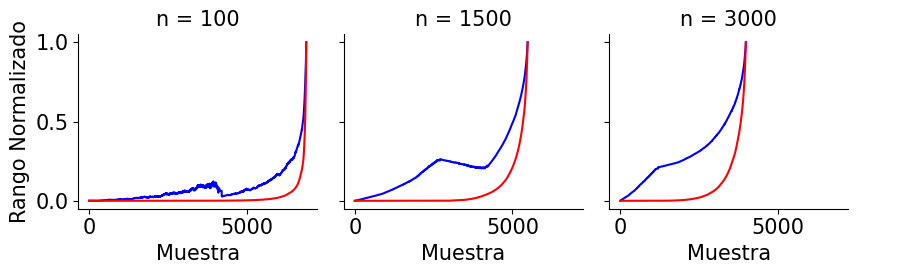

In [29]:
import seaborn as sns
label='f1(x): Total number of buildings'
label='f2(x): Class imbalance'
g1 = sns.FacetGrid(f1_f2_df, col='n', margin_titles=True)
g1.map_dataframe(sns.lineplot, 'samp_id', 'bld_tot_f1', color='blue')
g1.map_dataframe(sns.lineplot, 'samp_id', 'imb_rate_f2', color='red')
#g1.set_axis_labels('Sample Number', 'Normalized Range')
g1.set_axis_labels('Muestra', 'Rango Normalizado')
g1.add_legend()

In [30]:
f3_df = df_exp[["n","alpha","samp_id","composed_f3"]]
f3_df

,n,alpha,samp_id,composed_f3
0,100,0.3,0,0.002088
0,100,0.3,1,0.002115
0,100,0.3,2,0.002033
0,100,0.3,3,0.002033
0,100,0.3,4,0.001978
...,...,...,...,...
8,3000,0.7,3979,0.038317
8,3000,0.7,3980,0.029115
8,3000,0.7,3981,0.019518
8,3000,0.7,3982,0.009824


In [31]:
max_dot = f3_df.groupby(["n","alpha"]).apply(lambda x: x.reset_index(drop=True).loc[x.reset_index(drop=True)["composed_f3"].idxmax()], include_groups=False)
max_dot = max_dot.reset_index()
max_dot

,n,alpha,samp_id,composed_f3
0,100,0.3,6883,1.0
1,100,0.5,6774,1.0
2,100,0.7,6280,1.0
3,1500,0.3,5483,1.0
4,1500,0.5,4985,1.0
5,1500,0.7,2702,1.0
6,3000,0.3,3983,1.0
7,3000,0.5,3306,1.0
8,3000,0.7,2585,1.0


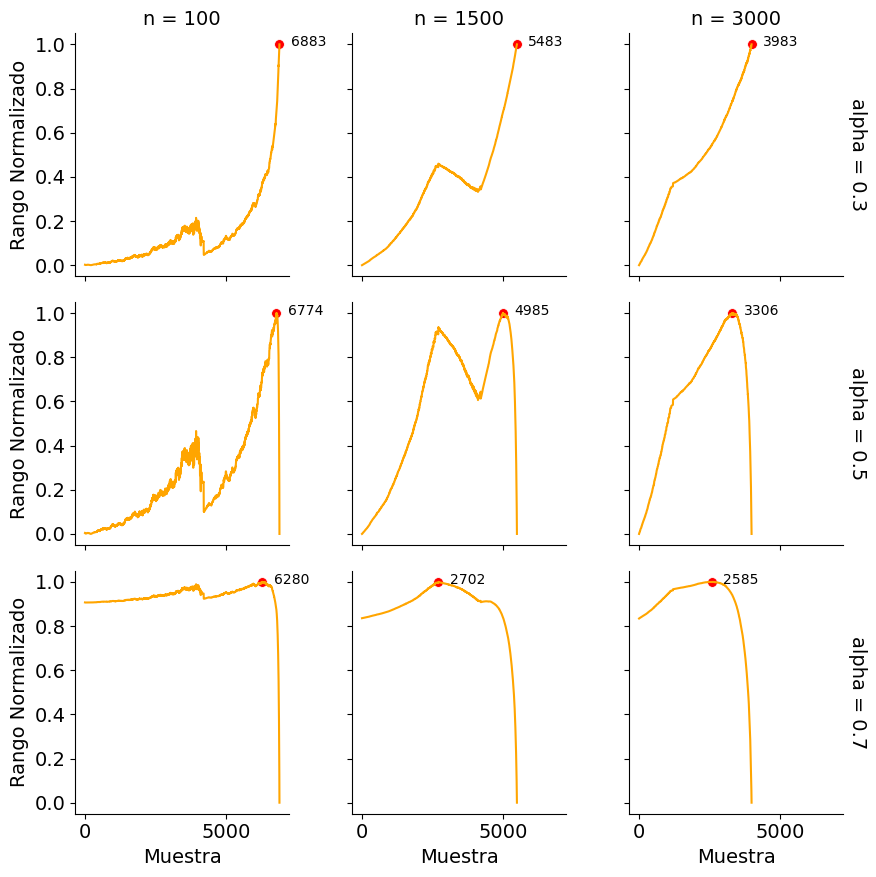

In [35]:
import seaborn as sns
plt.rcParams.update({'font.size': 14})

def my_scatter(data, max_df, **kwargs):
    # Filtrar los puntos máximos correspondientes a la faceta actual
    max_facet_data = max_df[(max_df['n'] == data['n'].iloc[0]) & (max_df['alpha'] == data['alpha'].iloc[0])]
    ax = plt.gca()
    # Graficar los puntos máximos
    sns.scatterplot(data=max_facet_data, x='samp_id', y='composed_f3', color='red', s=50, ax=ax)
    
    for i, row in max_facet_data.iterrows():
        ax.text(row['samp_id']+400, row['composed_f3']+0.01, str(int(row['samp_id'])),
                color='black',ma='left', ha='left', va='center', fontsize=10)
        
label = "f3(x) = alpha*f1(x) - (1-alpha)*f2(x)"
g2 = sns.FacetGrid(df_exp, row='alpha', col='n', margin_titles=True)
g2.map_dataframe(sns.lineplot, 'samp_id', 'composed_f3', color='orange')
g2.map_dataframe(my_scatter, max_df=max_dot)

#g2.set_axis_labels('Sample Number', 'Normalized Range')
g2.set_axis_labels('Muestra', 'Rango Normalizado')

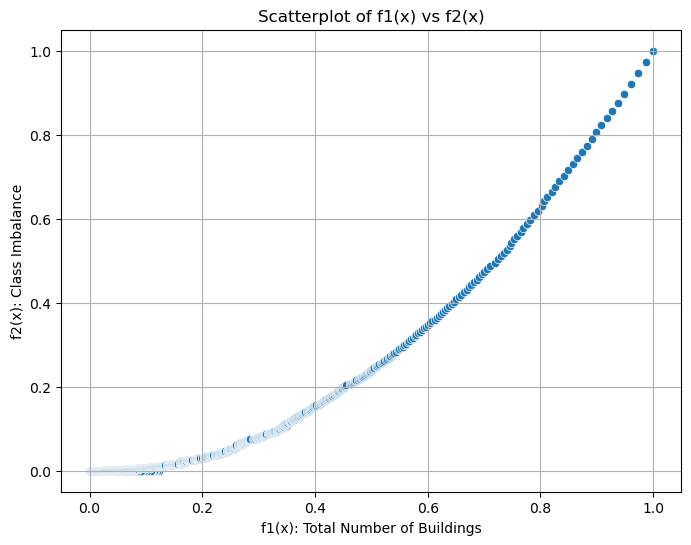

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tienes los valores de f1 y f2 en función de x
f1_values = f1_f2_df[f1_f2_df["n"]==100]['bld_tot_f1']  # Valores de f1(x)
f2_values = f1_f2_df[f1_f2_df["n"]==100]['imb_rate_f2']  # Valores de f2(x)

# Crear un scatterplot de f1 vs f2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=f1_values, y=f2_values)|

# Agregar etiquetas y título
plt.ylabel('f2(x): Class Imbalance')
plt.xlabel('f1(x): Total Number of Buildings')
plt.title('Scatterplot of f1(x) vs f2(x)')
plt.grid(True)
plt.show()
